In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

TensorFlow Hub is a way to share pretrained model components. See the TensorFlow Module Hub for a searchable listing of pre-trained models. This tutorial demonstrates:

1) How to use TensorFlow Hub with tf.keras.

2) How to do image classification using TensorFlow Hub.

3) How to do simple transfer learning.

In [5]:
import tensorflow_hub as hub

from tensorflow.keras import layers

# An ImageNet classifier
 Download the classifier
Use hub.module to load a mobilenet, and tf.keras.layers.Lambda to wrap it up as a keras layer. Any TensorFlow 2 compatible image classifier URL from tfhub.dev will work here.

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [6]:
IMAGE_SHAPE = (224,224)

classfier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

# Run it on a single image
Download a single image to try the model on.

In [8]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)

65536/61306 [================================] - 0s 1us/step


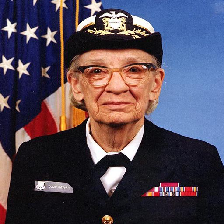

In [9]:
grace_hopper

In [10]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [11]:
#Add a batch dimension, and pass the image to the model.
results = classfier.predict(grace_hopper[np.newaxis, ...])
results.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:



In [13]:
predicted_class = np.argmax(results[0], axis=-1)
predicted_class

653

# Decode the predictions
We have the predicted class ID, Fetch the ImageNet labels, and decode the predictions

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


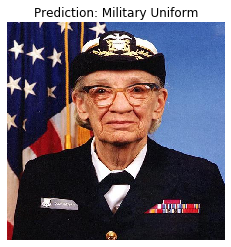

In [15]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())

# Simple transfer learning
Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

Dataset
For this example you will use the TensorFlow flowers dataset:

In [16]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

The simplest way to load this data into our model is using tf.keras.preprocessing.image.ImageDataGenerator,

All of TensorFlow Hub's image modules expect float inputs in the [0, 1] range. Use the ImageDataGenerator's rescale parameter to achieve this.

The image size will be handled later.

In [17]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [18]:
#The resulting object is an iterator that returns image_batch, label_batch pairs.

for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [20]:
#Run the classifier on a batch of images
result_batch = classfier.predict(image_batch)
result_batch.shape

(32, 1001)

In [21]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'handkerchief', 'admiral', 'bee', 'mushroom', 'daisy',
       'bee', 'picket fence', 'daisy', 'cup', 'daisy', 'daisy',
       'cucumber', 'bee', 'vase', 'daisy', "jack-o'-lantern", 'bee',
       'daisy', 'kimono', 'daisy', 'daisy', 'daisy', 'spider web',
       'teddy', 'hay', 'pot', 'conch', 'fountain', 'conch', 'pot',
       'ladybug'], dtype='<U30')

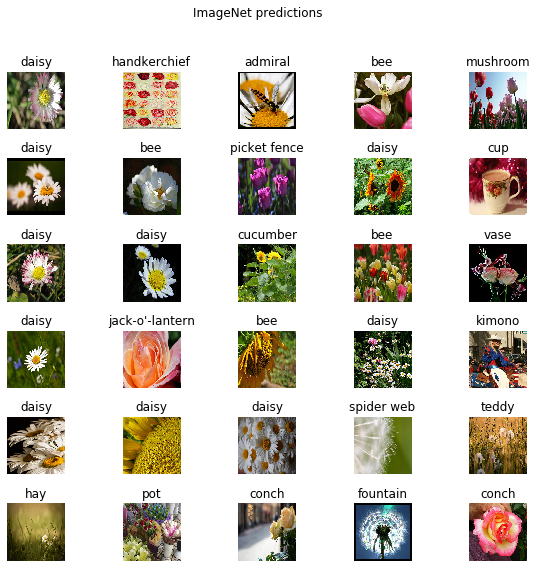

In [22]:
# Now check how these predictions line up with the images:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")



See the LICENSE.txt file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

# Download the headless model
TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any Tensorflow 2 compatible image feature vector URL from tfhub.dev will work here.

In [23]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


In [24]:
#Create the feature extractor.

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                        input_shape=(224,224,3))

In [25]:
#It returns a 1280-length vector for each image:

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [26]:
#Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

feature_extractor_layer.trainable=False

## Attach a classification head
Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

In [27]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [30]:
# Train the model Use compile to configure the training process:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['acc'])

Now use the .fit method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [31]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [33]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                             steps_per_epoch=steps_per_epoch,
                             callbacks= [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 115.0 steps
Epoch 1/2
115/115 [==============================] - 111s 967ms/step - loss: 0.6839 - acc: 0.7188
Epoch 2/2
115/115 [==============================] - 108s 943ms/step - loss: 0.3349 - acc: 0.9688


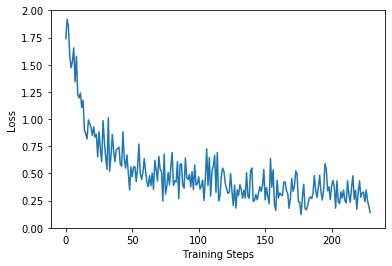

In [35]:
# Now after, even just a few training iterations, we can already see that the model is making progress on the task.

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

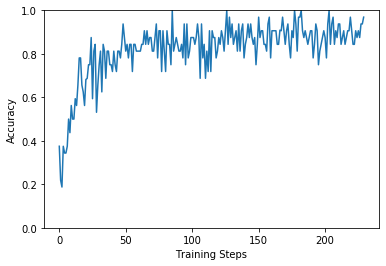

In [36]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

# Check the predictions
To redo the plot from before, first get the ordered list of class names:

In [37]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key,value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [38]:
#Run the image batch through the model and convert the indices to class names.

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [40]:
#plot results
label_id = np.argmax(label_batch, axis=-1)

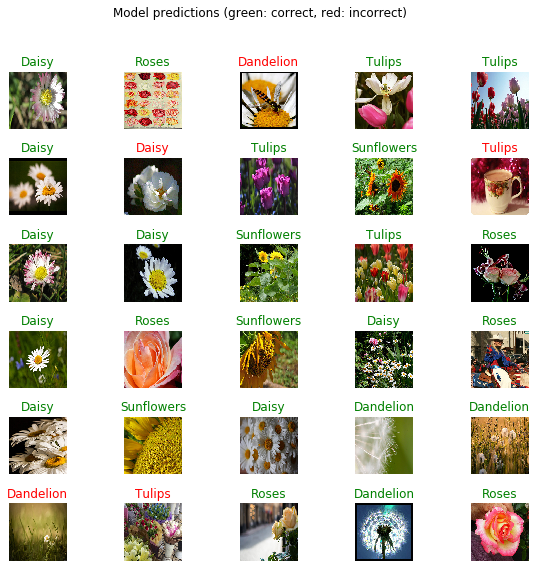

In [42]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5, n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Export your model
Now that you've trained the model, export it as a saved model:

In [43]:
import time
t = time.time()

export_path = '/tmp/saved_models/{}'.format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1584315980/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1584315980/assets


'/tmp/saved_models/1584315980'

Now confirm that we can reload it, and it still gives the same results:

This saved model can be loaded for inference later, or converted to TFLite or TFjs.

In [44]:
reloaded = tf.keras.models.load_model(export_path)

In [45]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [48]:
abs(reloaded_result_batch - result_batch).sum()

0.0